Imports

In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import statsmodels.stats.api as sms
from datetime import datetime
import glob
from zedstat import zedstat

from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

Function definitions

In [2]:
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _sample_with_dissonance(
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    if order is None:
        order = range(length)

    if data_samples is not None:
        data_samples_df = pd.DataFrame(data_samples)
        data_sample_values = pd.Series(
            {col: data_samples_df[col].unique() for col in data_samples_df}
        )

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    for i in order:
        if sample_model is not None:
            prob_dict = sample_model.predict_distribution(sample, i)
            sample[i] = sample_from_dict(prob_dict)
        else:
            sample[i] = random.choice(data_sample_values[i])
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples,
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    n_runif_samples=None,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = {}
    dissonances = {}

    if order == "entropy":
        Ds = qsample_model.predict_distributions(np.full(length, ""))
        entrpy = list()
        for i in range(len(Ds)):
            entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
        order = pd.Series(entrpy).sort_values().index

    if order == "random":
        order = list(range(length))
        random.shuffle(order)

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples, m2_model, length, diss_models, diss_fcn, order
    )

    if n_runif_samples is not None:
        samples["runif"], dissonances["runif"] = _nsamples_with_dissonance(
            n_runif_samples,
            None,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

Example: Fit models, then generate base qsamples from the full model, m2 samples as qsamples from the positive only model, and compute dissonances under all models.

In [ ]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/ptsd/PTSD_cognet_test_processed.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

Tr_pos = truthnet()
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

Tr_neg = truthnet()
feat_neg, samp_neg = Tr_neg.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_neg_only.csv"
)
Tr_neg.fit(modelpath="tmp_Qnet_neg.joblib")

In [ ]:
full_model = Tr.model_obj.myQnet
pos_model = Tr_pos.model_obj.myQnet
neg_model = Tr_neg.model_obj.myQnet

diss_models = [full_model, neg_model, pos_model]
n_qsamples = 100
n_m2_samples = 100
n_runif_samples = 100

s, d = _sampling_scenario(
    n_qsamples,
    full_model,
    n_m2_samples,
    pos_model,
    diss_models,
    211,
    n_runif_samples,
    data_samples=samples,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Save dissonances to file:

In [ ]:
[
    _diss_dataset(d, questions, groups=["qsampled", "m2", "runif"]).to_csv(
        f"diss_ex_data/diss_questions_asked_{str(questions)}", index=False
    )
    for questions in range(1, 150)
]

Check saved dissonances:

In [ ]:
questions_asked = 14
pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}").query(
    "y.isin(@groups)"
)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,y
0,0.198767,0.000000,0.546875,0.745979,0.908464,0.100605,0.000000,0.402879,0.149533,0.000000,...,0.000000,0.495190,0.008022,0.083333,0.337861,0.600000,0.800000,1.000,0.928571,qsampled
1,0.744850,0.000000,0.000000,0.000000,0.000000,0.766238,0.416082,0.379902,0.149533,0.545455,...,1.000000,0.896709,1.000000,0.083333,0.584148,1.000000,0.800000,1.000,0.928571,qsampled
2,0.000000,0.728045,0.546875,0.000000,0.674195,0.000000,0.528914,0.000000,0.500000,0.000000,...,0.215859,1.000000,0.491286,0.000000,0.584148,0.000000,0.400000,0.000,0.142857,qsampled
3,0.754243,0.445505,0.723077,0.449149,0.888889,0.982609,0.105525,0.269652,1.000000,0.000000,...,1.000000,0.386139,1.000000,0.000000,0.362479,0.416667,0.342857,1.000,1.000000,qsampled
4,0.401491,0.000000,0.000000,0.425088,0.000000,1.000000,0.808814,0.362631,0.500000,0.545455,...,0.000000,0.000000,1.000000,0.000000,0.584148,0.416667,0.000000,1.000,0.000000,qsampled
5,0.754721,0.000000,0.656250,0.000000,0.000000,0.766238,0.416082,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.291667,0.342020,1.000000,0.800000,0.000,0.142857,qsampled
6,0.284964,0.559513,0.375000,0.000000,0.000000,0.000000,0.157179,0.179982,0.500000,0.545455,...,0.867647,0.890851,0.000000,0.083333,0.337861,0.000000,0.000000,1.000,0.142857,qsampled
7,0.389013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418933,0.500000,0.454545,...,0.410594,0.460139,0.008022,0.083333,0.000000,0.416667,0.400000,1.000,0.142857,qsampled
8,0.363337,0.000000,0.000000,0.235192,0.000000,0.000000,0.216255,0.361051,0.000000,0.454545,...,0.409861,0.000000,0.000000,0.291667,0.000000,0.000000,0.800000,0.875,1.000000,qsampled
9,0.756110,0.435764,0.907692,0.449149,0.000000,0.748455,0.367254,0.818965,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.291667,0.362479,0.000000,0.342857,1.000,0.928571,qsampled


Plot dissonances:

In [ ]:
pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}").query(
    "y.isin(@groups)"
).iloc[:, np.r_[:questions_asked]]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.733833,0.003398,0.546875,0.356186,0.000000,0.766238,0.528914,0.826216,0.728444,0.000000,0.867737,0.000000,0.342666,0.000000,0.000000,0.829269,0.242857,0.132676,0.778502
1,0.754243,0.000000,0.000000,0.235192,0.000000,0.647619,0.070258,0.108907,0.917037,0.454545,0.253853,0.000000,0.000000,0.000000,1.000000,0.782050,0.228571,0.393246,0.740881
2,0.047219,0.005793,0.546875,0.356186,0.680699,0.100605,0.216255,0.348705,0.395851,0.000000,0.484292,0.000000,0.028763,0.084050,0.000000,0.777938,0.828571,0.215086,0.242571
3,0.368020,0.000000,0.265625,0.000000,0.864052,0.766238,0.416082,0.000000,0.000000,0.000000,0.886081,0.000000,0.023849,0.000000,0.849528,0.310592,0.828571,0.215086,0.553961
4,0.481652,0.000000,0.265625,0.000000,0.000000,0.000000,0.416082,0.824306,0.730370,0.000000,0.000000,0.366844,0.961030,0.760360,0.000000,0.310592,0.228571,0.169018,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.351534,0.000000,0.000000,0.000000,0.000000,0.766238,0.000000,0.386645,0.534440,0.000000,0.000000,0.756677,0.000000,0.084050,0.000000,0.858544,0.000000,0.557234,0.246787
296,0.000000,0.494231,0.723077,0.586885,0.855421,0.725808,0.416082,0.962888,0.395851,0.454545,0.696649,0.108021,0.342688,0.000000,0.753656,0.310592,0.571429,0.600861,0.236296
297,0.144850,0.147698,0.546875,0.925679,0.864052,0.100605,0.416082,0.360544,0.813953,0.000000,0.000000,0.108037,0.803440,0.356368,0.433142,0.493447,0.242857,0.000000,0.236296
298,0.733833,0.193385,0.000000,0.068034,0.903279,0.326983,0.812767,0.813782,0.813953,1.000000,0.972456,0.373298,0.803440,0.774824,0.175985,0.000000,0.242857,0.601230,0.236296


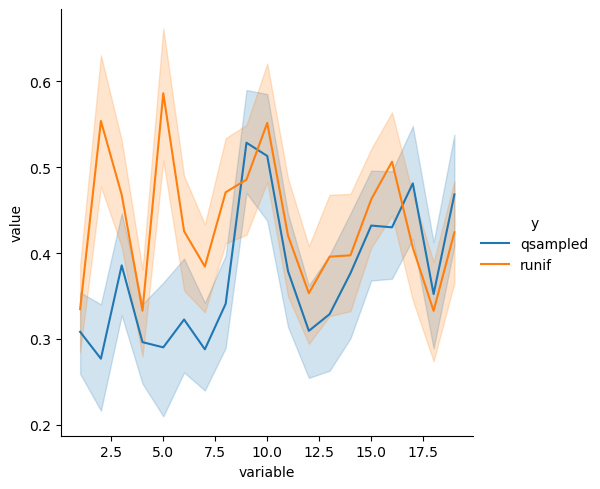

In [ ]:
groups = ["qsampled", "runif"]
questions_asked = 19
df = (
    pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}")
    .query("y.isin(@groups)")
    .iloc[:, np.r_[:questions_asked, -1]]
)
df = pd.melt(df, id_vars="y")
df["variable"] = (df["variable"].astype(int) % questions_asked) + 1

sns.relplot(data=df, x="variable", y="value", hue="y", kind="line")

In [ ]:
groups = ["qsampled", "runif"]
questions_asked = 19
df = pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}").query(
    "y.isin(@groups)"
)

pd.concat(
    [df.iloc[:, np.r_[:questions_asked]].mean(axis=1, numeric_only=True), df["y"]],
    axis=1,
).groupby("y", as_index=False).mean()

,y,0
0,qsampled,0.374057
1,runif,0.436380


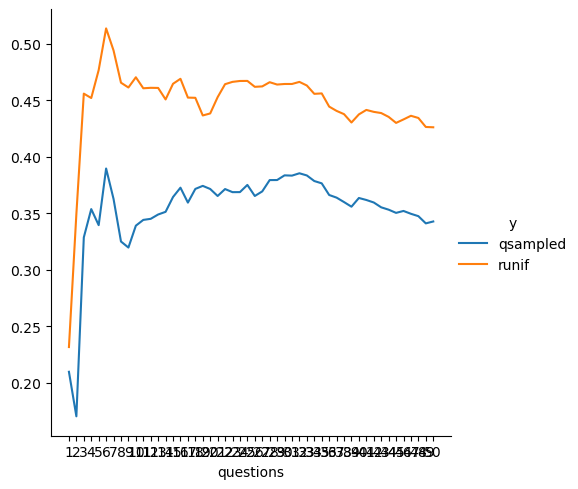

In [ ]:
dff = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}")
                .query("y.isin(@groups)")
                .iloc[:, np.r_[:questions_asked]]
                .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"diss_ex_data/diss_questions_asked_{str(questions_asked)}"
                ).query("y.isin(@groups)")["y"],
            ],
            axis=1,
        )
        .groupby("y", as_index=False)
        .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 51)
    ]
)

sns.relplot(data=dff, x="questions", y=0, hue="y", kind="line")

In [ ]:
dff

,y,0,questions
0,qsampled,0.209494,1
1,runif,0.231392,1
0,qsampled,0.170080,2
1,runif,0.349163,2
0,qsampled,0.328437,3
...,...,...,...
1,runif,0.434157,48
0,qsampled,0.340863,49
1,runif,0.426190,49
0,qsampled,0.342538,50


In [ ]:
pd.concat(
    [
        pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}")
        .query("y.isin(@groups)")
        .iloc[:, np.r_[:questions_asked]]
        .mean(axis=1, numeric_only=True)
        for questions_asked in range(1, 10)
    ],
    axis=1,
)

,0,1,2,3,4,5,6,7,8
0,0.417722,0.275527,0.257576,0.418947,0.335158,0.279353,0.330354,0.478640,0.474264
1,0.227848,0.113924,0.291309,0.245365,0.196292,0.222283,0.196300,0.331004,0.374184
2,0.417722,0.275527,0.257576,0.418947,0.471236,0.544914,0.523346,0.306888,0.352759
3,0.253165,0.126582,0.274743,0.163421,0.299394,0.249625,0.213964,0.330636,0.312813
4,0.417722,0.208861,0.299619,0.182078,0.145662,0.179524,0.153878,0.246727,0.268118
...,...,...,...,...,...,...,...,...,...
295,0.417722,0.208861,0.196782,0.115672,0.092537,0.077229,0.071968,0.189906,0.185420
296,0.000000,0.066667,0.236998,0.440325,0.523339,0.600181,0.515832,0.587727,0.602386
297,0.253165,0.126582,0.450303,0.715243,0.740851,0.772845,0.644912,0.499754,0.446525
298,0.417722,0.208861,0.510909,0.409568,0.498774,0.582339,0.620592,0.555137,0.498753


# Compute AUCs

Use dissonance for each question as features:

In [ ]:
groups = ["qsampled", "runif"]
question_iter = range(1, 20)

classifier = RandomForestClassifier(n_jobs=-1)

for questions_asked in tqdm(question_iter):
    data = pd.read_csv(
        f"diss_ex_data/diss_questions_asked_{str(questions_asked)}"
    ).query("y.isin(@groups)")
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop("y", axis="columns"), data["y"], test_size=0.33
    )

    classifier.fit(
        X_train.to_numpy(),
        y_train.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
    )

    r = RocCurveDisplay.from_estimator(
        classifier,
        X_test.to_numpy(),
        y_test.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
        pos_label=1,
        name=questions_asked,
    )
    plt.close()
    print(f"AUC ({questions_asked} questions): {r.roc_auc}")

  0%|          | 0/19 [00:00<?, ?it/s]

AUC (1 questions): 0.44266917293233077
AUC (2 questions): 0.6654411764705883
AUC (3 questions): 0.5759734093067426
AUC (4 questions): 0.6015037593984963
AUC (5 questions): 0.6923076923076923
AUC (6 questions): 0.7345622119815668
AUC (7 questions): 0.7993421052631579
AUC (8 questions): 0.7670083876980428
AUC (9 questions): 0.8212962962962963
AUC (10 questions): 0.8337962962962963
AUC (11 questions): 0.7537593984962406
AUC (12 questions): 0.9162037037037037
AUC (13 questions): 0.8671947809878845
AUC (14 questions): 0.8893518518518518
AUC (15 questions): 0.8516129032258065
AUC (16 questions): 0.837962962962963
AUC (17 questions): 0.8345864661654137
AUC (18 questions): 0.8405330882352942
AUC (19 questions): 0.7870967741935483


Use mean dissonance of available questions as features:

In [ ]:
groups = ["qsampled", "runif"]
question_iter = range(1, 20)

classifier = RandomForestClassifier(n_jobs=-1)

for questions_asked in tqdm(question_iter):
    data = pd.concat(
        [
            pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}")
            .query("y.isin(@groups)")
            .iloc[:, np.r_[:questions_asked]]
            .mean(axis=1, numeric_only=True)
            for questions_asked in range(1, 10)
        ],
        axis=1,
    )
    X_train, X_test, y_train, y_test = train_test_split(
        data,
        pd.read_csv(f"diss_ex_data/diss_questions_asked_{str(questions_asked)}").query(
            "y.isin(@groups)"
        )["y"],
        test_size=0.33,
    )

    classifier.fit(
        X_train,
        y_train.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
    )

    r = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
        pos_label=1,
        name=questions_asked,
    )
    plt.close()
    print(f"AUC ({questions_asked} questions): {r.roc_auc}")

  0%|          | 0/19 [00:00<?, ?it/s]

AUC (1 questions): 0.854912764003673
AUC (2 questions): 0.7414746543778802
AUC (3 questions): 0.828110599078341
AUC (4 questions): 0.856221198156682
AUC (5 questions): 0.7964154411764705
AUC (6 questions): 0.7582720588235294
AUC (7 questions): 0.7835477941176471
AUC (8 questions): 0.8023897058823529
AUC (9 questions): 0.7817095588235293
AUC (10 questions): 0.8512396694214877
AUC (11 questions): 0.7457706766917294
AUC (12 questions): 0.8282407407407408
AUC (13 questions): 0.7499999999999999
AUC (14 questions): 0.8308480894687791
AUC (15 questions): 0.8347222222222223
AUC (16 questions): 0.7695852534562212
AUC (17 questions): 0.8207720588235293
AUC (18 questions): 0.7600961538461539
AUC (19 questions): 0.8364398881640261
